In [2]:
import ee
import geemap
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1ARtbsJoOfccWuAsfeqb39yXDkvsLJFiMlgHJ61QI5EL-Pvs846Niph-tztg

Successfully saved authorization token.


In [3]:
# Define a region of interest
roi = ee.Geometry.Rectangle([70.7980547394194417, 23.2880385161501735, 71.5060515087354958, 23.9024834537972986]); # Nanda Bet small region


In [4]:
# Import S1 data
d1 = '2020-01-01'
d2 = '2021-01-01'
img_collection = (ee.ImageCollection('COPERNICUS/S1_GRD')
    .filter(ee.Filter.eq('instrumentMode', 'IW'))
    .filterMetadata('resolution_meters', 'equals', 10)
    .filter(ee.Filter.eq('orbitProperties_pass', 'DESCENDING'))
    .filterBounds(roi)
    .filterDate(d1, d2)
    .select('VV', 'VH'))
    

In [5]:
# Define function to get VV/VH ratio
def get_vv_vh_ratio(img):
    vv = img.select('VV')
    vh = img.select('VH')
    vv_vh = vv.subtract(vh).rename('VV_VH')
    img = img.addBands(vv_vh)
    return img

In [6]:
# Get vv, vh, vv/vh bands
vv_vh_collection = img_collection.map(get_vv_vh_ratio).select('VV_VH')
vv_collection = img_collection.select('VV')
vh_collection = img_collection.select('VH')

n = vv_collection.size().getInfo()
vv_list = vv_collection.toList(n)
vh_list = vh_collection.toList(n)
vv_vh_list = vv_vh_collection.toList(n)

print(n, 'images')

31 images


In [7]:
# Get dates of all images in image collection
date_list = []
for i in range(0, n):
    img = ee.Image(vv_collection.toList(n).get(i))
    t_ms = img.get('system:time_start').getInfo()
    dt = datetime.fromtimestamp(t_ms/1000.0)
    d = dt.strftime("%m/%d/%Y")
    date_list.append(d)

# print(date_list)
    

In [15]:
import time
acq_times = vv_collection.aggregate_array('system:time_start').getInfo()
date_list = [time.strftime('%m-%d-%Y', time.gmtime(t/1000)) for t in acq_times]
print(date_list)

['01-03-2020', '01-15-2020', '01-27-2020', '02-08-2020', '02-20-2020', '03-03-2020', '03-15-2020', '03-27-2020', '04-08-2020', '04-20-2020', '05-02-2020', '05-14-2020', '05-26-2020', '06-07-2020', '06-19-2020', '07-01-2020', '07-13-2020', '07-25-2020', '08-06-2020', '08-18-2020', '08-30-2020', '09-11-2020', '09-23-2020', '10-05-2020', '10-17-2020', '10-29-2020', '11-10-2020', '11-22-2020', '12-04-2020', '12-16-2020', '12-28-2020']


In [8]:
# Define visualization parameters for map
vv_vis = {
    'min': -20,
    'max': -5,
    'palette': ['#000000','#ffffff']
}

vh_vis = {
    'min': -25,
    'max': -10,
    'palette': ['#000000','#ffffff']
}

vv_vh_vis = {
    'min': 0,
    'max': 15,
    'palette': ['#000000','#ffffff']
}

# convert to power, take sqrt of the power -- accentuates the lower values & de-emphasizes the higher values

In [9]:
print(date_list)

['01/02/2020', '01/14/2020', '01/26/2020', '02/07/2020', '02/19/2020', '03/02/2020', '03/14/2020', '03/26/2020', '04/07/2020', '04/19/2020', '05/01/2020', '05/13/2020', '05/25/2020', '06/06/2020', '06/18/2020', '06/30/2020', '07/12/2020', '07/24/2020', '08/05/2020', '08/17/2020', '08/29/2020', '09/10/2020', '09/22/2020', '10/04/2020', '10/16/2020', '10/28/2020', '11/09/2020', '11/21/2020', '12/03/2020', '12/15/2020', '12/27/2020']


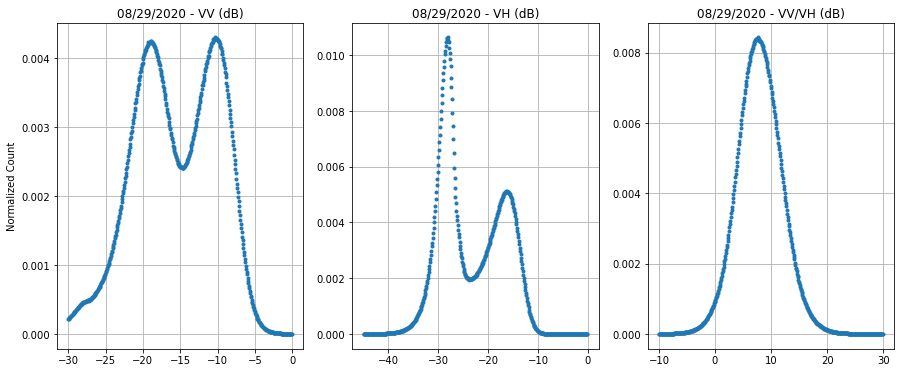

Map(center=[23.595422252032954, 71.15205312407748], controls=(WidgetControl(options=['position', 'transparent_…

In [13]:
# Create histograms, map, and add s1 images for the selected date

idx = 20 # image to display


# histograms of vv, vh, vv/vh
hist_vv = ee.Image(vv_list.get(idx)).reduceRegion(
        ee.Reducer.fixedHistogram(-30, 0, 500),roi,maxPixels=50000000).get('VV').getInfo()
a_vv = np.array(hist_vv)
x_vv = a_vv[:, 0]                 # array of bucket edge positions
y_vv = a_vv[:, 1]/np.sum(a_vv[:, 1]) # normalized array of bucket contents

hist_vh = ee.Image(vh_list.get(idx)).reduceRegion(
        ee.Reducer.fixedHistogram(-45, 0, 500),roi,maxPixels=50000000).get('VH').getInfo()
a_vh = np.array(hist_vh)
x_vh = a_vh[:, 0]                 
y_vh = a_vh[:, 1]/np.sum(a_vh[:, 1]) 

hist_vv_vh = ee.Image(vv_vh_list.get(idx)).reduceRegion(
        ee.Reducer.fixedHistogram(-10, 30, 500),roi,maxPixels=50000000).get('VV_VH').getInfo()
a_vv_vh = np.array(hist_vv_vh)
x_vv_vh = a_vv_vh[:, 0]                 
y_vv_vh = a_vv_vh[:, 1]/np.sum(a_vv_vh[:, 1]) 


# Create 3 subplots for histograms
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[15,6])
ax1.grid()
ax1.plot(x_vv, y_vv, '.')
ax1.set_ylabel('Normalized Count')
ax1.set_title(date_list[idx] + ' - VV (dB)')

ax2.grid()
ax2.plot(x_vh, y_vh, '.')
ax2.set_title(date_list[idx] + ' - VH (dB)')

ax3.grid()
ax3.plot(x_vv_vh, y_vv_vh, '.')
ax3.set_title(date_list[idx] + ' - VV/VH (dB)')

plt.show()


# Create map and add layers
Map = geemap.Map()
Map.centerObject(roi, 8)
Map.addLayer(ee.Image(vv_list.get(idx)),vv_vis,'VV')
Map.addLayer(ee.Image(vh_list.get(idx)),vh_vis,'VH')
Map.addLayer(ee.Image(vv_vh_list.get(idx)),vv_vh_vis,'VV/VH')
Map


In [10]:
# Define arguments for animation function procedures
vv_args = {
    'dimensions': 750,
    'framesPerSecond': 1,
    'crs': 'EPSG:3857',
    'min': -20,
    'max': -5
}

vh_args = {
    'dimensions': 750,
    'framesPerSecond': 1,
    'crs': 'EPSG:3857',
    'min': -25,
    'max': -10
}

vv_vh_args = {
    'dimensions': 750,
    'framesPerSecond': 1,
    'crs': 'EPSG:3857',
    'min': 0,
    'max': 15
}

In [11]:
# Save GIF to local drive
vv_file = r"C:\Users\brand\Documents\python\nanda_bet\gifs\s1_vv_20200101_20201231.gif"
geemap.download_ee_video(vv_collection, vv_args, vv_file)

vh_file = r"C:\Users\brand\Documents\python\nanda_bet\gifs\s1_vh_20200101_20201231.gif"
geemap.download_ee_video(vh_collection, vh_args, vh_file)

vv_vh_file = r"C:\Users\brand\Documents\python\nanda_bet\gifs\s1_vv_vh_20200101_20201231.gif"
geemap.download_ee_video(vv_vh_collection, vv_vh_args, vv_vh_file)


Generating URL...
Please wait ...
The GIF image has been saved to: C:\Users\brand\Documents\python\nanda_bet\gifs\s1_vv_20200101_20201231.gif
Generating URL...
Please wait ...
The GIF image has been saved to: C:\Users\brand\Documents\python\nanda_bet\gifs\s1_vh_20200101_20201231.gif
Generating URL...
Please wait ...
The GIF image has been saved to: C:\Users\brand\Documents\python\nanda_bet\gifs\s1_vv_vh_20200101_20201231.gif


In [ ]:
# Show VV or VH GIF

#geemap.show_image(vv_file)
#geemap.show_image(vh_file)
#geemap.show_image(vv_vh_file)


In [12]:
# Add text and colorbar to GIFs

fps = 1 # frames per second
vv_file2 = r"C:\Users\brand\Documents\python\nanda_bet\gifs\s1_vv_20200101_20201231_annotated.gif"
vh_file2 = r"C:\Users\brand\Documents\python\nanda_bet\gifs\s1_vh_20200101_20201231_annotated.gif"
vv_vh_file2 = r"C:\Users\brand\Documents\python\nanda_bet\gifs\s1_vv_vh_20200101_20201231_annotated.gif"

def add_text_and_colorbar_to_gis(in_file,out_file,fps,labels,cbar_txt):
    
    geemap.add_text_to_gif(
        in_file,
        out_file,
        xy=('75%', '5%'),
        text_sequence=date_list,
        font_size=30,
        font_color='#ffffff',
        duration=int(1000 / fps),
        add_progress_bar=True
    )

    geemap.add_text_to_gif(
        out_file, 
        out_file,
        xy=('12%', '93%'), 
        text_sequence=cbar_txt, 
        font_color='white',
        font_size = 20,
        duration=int(1000/fps)
    )

    # create a colorbar
    width = 250
    height = 30
    palette = ['black', 'white']
    labels = labels
    colorbar = geemap.create_colorbar(
        width=width,
        height=height,
        palette=palette,
        vertical=False,
        font_size=25,
        font_color='white',
        labels=labels,
    )

    # add colorbar to gif
    geemap.add_image_to_gif(
        out_file, 
        out_file, 
        in_image=colorbar, 
        xy=('0%', '88%'), 
        image_size=(250, 250)
    )


labels = [-20, -5]    
cbar_txt = "VV (dB)"
add_text_and_colorbar_to_gis(vv_file,vv_file2,fps,labels,cbar_txt)

labels = [-25, -10]    
cbar_txt = "VH (dB)"
add_text_and_colorbar_to_gis(vh_file,vh_file2,fps,labels,cbar_txt)

labels = [0, 15]    
cbar_txt = "VV/VH (dB)"
add_text_and_colorbar_to_gis(vv_vh_file,vv_vh_file2,fps,labels,cbar_txt)


In [13]:
# Show gifs
geemap.show_image(vv_file2)
#geemap.show_image(vh_file2)
#geemap.show_image(vv_vh_file2)

Output()